Deliverables/tasks: 
A PDF document with all models and detailed error analysis and the Python notebook with detailed code (with comments).
Recommend writeup: 7-8 pages and Python notebook.
You will be evaluated based on the rigor, breadth and depth of your modeling with high importance to error analysis  and  observations from it. Error Analysis should lead you to design better features and models which should be covered in this phase. More insightful the error-analysis and downstream feature engineering and modeling, the better.
Base-line model and metrics
Try out incrementally more complex models as long as they satisfy the real-world constraints and requirements.
Can you modify various aspects of the existing algorithms to make it work better for your needs? E.g: pick a better loss-function, pick a better sampling, better optimizer etc.
Hyper-parm tune your models using various approaches including black-box optimization methods.
Thorough Error analysis on your best models. Key observations and how can this analysis help you better design new features or models (in the next phase).
Robustness of your best models.
What are the pros and cons of the models you used? When and where should each of them be used in real world applications? 


In [18]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Classifier - 1st check

1.   One of the main data set "train.csv" has 4617600 rows of data
2.   Among the total rows we have 4498904 rows where 0 units only sold
3.   So it's clearly unblanaced data set
4.   To overcome this we will us a classifier algorithm first, just to check whether query point's output is 0 or not
5. If 0 then it will share the same infrmation else, it will goto Regression Algo used at downside flow

**Classifier Algorithm to detect if outcome is 0 or not**

We are going to use Logistic Regression, as it's accuracy & F1-Score is best compare to other classifiers

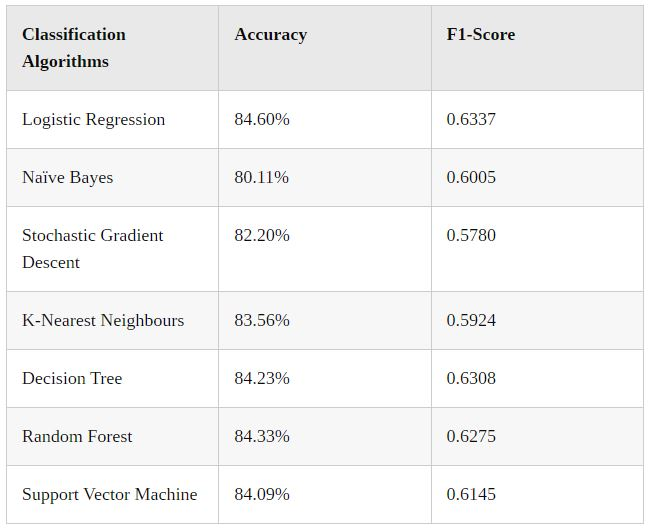

In [19]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

/bin/bash: nvidia-smi: command not found
Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Downloading the Data

In [37]:
#Loading the data
from google.colab import drive
drive.mount('/content/drive')

df_train = pd.read_csv("/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/train.csv")
df_weather_cleaned = pd.read_csv("/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/weather_cleaned.csv")
df_key = pd.read_csv("/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/key.csv")
df_weather_cleaned.head(2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,codesum_BCFG,codesum_BLDU,codesum_BLSN,codesum_BR,codesum_DU,codesum_DZ,codesum_FG,codesum_FG+,codesum_FU,codesum_FZDZ,codesum_FZFG,codesum_FZRA,codesum_GR,codesum_GS,codesum_HZ,codesum_MIFG,codesum_PL,codesum_PRFG,codesum_RA,codesum_SG,codesum_SN,codesum_SQ,codesum_TS,codesum_TSRA,codesum_TSSN,codesum_UP,codesum_VCFG,codesum_VCTS,codesum_nan,Day,Month,Quarter,Holiday
0,1,2012-01-01,52.0,31.0,42.0,1.5,36.0,40.0,23.0,0.0,0.0,0.05,29.78,29.92,3.6,20.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,False
1,2,2012-01-01,48.0,33.0,41.0,16.0,37.0,39.0,24.0,0.0,0.0,0.07,28.82,29.91,9.1,23.0,11.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,False


**Removing top level outliers, but keeping 0's, have used IQR. The higher threshold is set as per the EDA**

In [38]:
df_train = df_train[df_train['units'] <=133]
df_train[["units"]].max(axis=0)

units    133
dtype: int64

Merging Data sets for the Classification Model

In [39]:
df_train_key = df_train.merge(df_key, how='left', on='store_nbr')
df_train_key_weather = df_train_key.merge(df_weather_cleaned, how='left', on=['station_nbr','date'])
#df_train_key_weather.head(2)

Removing the not requiered Features as per EDA

In [41]:
remove_col=['sealevel','Quarter', 'dewpoint', 'heat', 'tavg', 'tmin', 'wetbulb']
df_Classifier_cleand = df_train_key_weather.drop(remove_col,axis=1).copy()

Creating a new feature for classfication purpose: 1= Units sold more than 1;
0 = No Unit sold 

In [42]:
df_Classifier_cleand.loc[df_Classifier_cleand['units'] == 0, 'flag'] = 0
df_Classifier_cleand.loc[df_Classifier_cleand['units']  > 0, 'flag'] = 1
df_Classifier_cleand.flag = df_Classifier_cleand.flag.astype('int64')
bkupdf_Classifier_cleand = df_Classifier_cleand.copy()
df_Classifier_cleand.head(2)

,date,store_nbr,item_nbr,units,station_nbr,tmax,depart,cool,snowfall,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,codesum_BCFG,codesum_BLDU,codesum_BLSN,codesum_BR,codesum_DU,codesum_DZ,codesum_FG,codesum_FG+,codesum_FU,codesum_FZDZ,codesum_FZFG,codesum_FZRA,codesum_GR,codesum_GS,codesum_HZ,codesum_MIFG,codesum_PL,codesum_PRFG,codesum_RA,codesum_SG,codesum_SN,codesum_SQ,codesum_TS,codesum_TSRA,codesum_TSSN,codesum_UP,codesum_VCFG,codesum_VCTS,codesum_nan,Day,Month,Holiday,flag
0,2012-01-01,1,1,0,1,52.0,1.5,0.0,0.0,0.05,29.78,3.6,20.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,False,0
1,2012-01-01,1,2,0,1,52.0,1.5,0.0,0.0,0.05,29.78,3.6,20.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,False,0


In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [45]:
y = df_Classifier_cleand.flag # define the target variable (dependent variable) as y
df_Classifier_LgRgresn = df_Classifier_cleand.drop(['date','flag'],axis = 1).copy()

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df_Classifier_LgRgresn, y, test_size=0.2,shuffle=False,stratify=None)
#X_train, X_test, y_train, y_test = train_test_split(df_Classifier_LgRgresn, y, test_size=0.2,random_state=6)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(3690090, 45) (3690090,)
(922523, 45) (922523,)


In [13]:
y_train.unique()

array([0, 1])

In [46]:
model_cls = LogisticRegression(solver='liblinear', random_state=6)
model_cls.fit(X_train, y_train)

LogisticRegression(random_state=6, solver='liblinear')

**Saving the Logistic Regression model as Pickle file for Production purpose**

In [53]:
from joblib import dump, load
dump(model_cls, '/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/cls_LogisticRegrsn.pkl')

['/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/cls_LogisticRegrsn.pkl']

In [48]:
y_pred=model_cls.predict(X_test)

In [49]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[901419,      0],
       [     0,  21104]])

Text(0.5, 257.44, 'Predicted label')

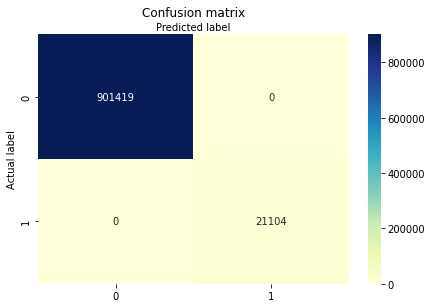

In [50]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [51]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1-Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


**Precision:** Precision is about being precise, i.e., how accurate our model is. In other words, we can say, when this model makes a prediction, how often it is correct. In this prediction case, when our Logistic Regression model predicted sales are going to happen, that is 100% of the time.

**Recall:** If there is no sales in the test set and our Logistic Regression model can identify it 100% of the time.

**Accuracy:** **(True Positive + True Negative) / Total Population**
Accuracy is a ratio of correctly predicted observation to the total observations. Accuracy is the most intuitive performance measure.
True Positive: The number of correct predictions that the occurrence is positive
True Negative: The number of correct predictions that the occurrence is negative
**F1-Score: (2 x Precision x Recall) / (Precision + Recall)**
F1-Score is the weighted average of Precision and Recall used in all types of classification algorithms. Therefore, this score takes both false positives and false negatives into account. F1-Score is usually more useful than accuracy, especially if you have an uneven class distribution.

Precision: When a positive value is predicted, how often is the prediction correct?
Recall: When the actual value is positive, how often is the prediction correct?

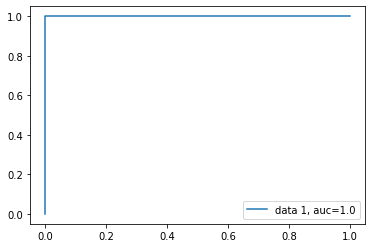

In [52]:
y_pred_proba = model_cls.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Base Line Model

In [9]:
#Loading the data
from google.colab import drive
drive.mount('/content/drive')

df_Merged_cleand = pd.read_csv("/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/df_Merged_cleand.csv")
df_Merged_cleand.head(2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,store_nbr,item_nbr,station_nbr,tmax,depart,cool,snowfall,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,Day,Month,Holiday,codesum_BCFG,codesum_BLDU,codesum_BLSN,codesum_BR,codesum_DU,codesum_DZ,codesum_FG,codesum_FG+,codesum_FU,codesum_FZDZ,codesum_FZFG,codesum_FZRA,codesum_GR,codesum_GS,codesum_HZ,codesum_MIFG,codesum_PL,codesum_PRFG,codesum_RA,codesum_SG,codesum_SN,codesum_SQ,codesum_TS,codesum_TSRA,codesum_TSSN,codesum_UP,codesum_VCFG,codesum_VCTS,codesum_nan,units
0,2012-01-01,1,9,1,52.0,1.5,0.0,0.0,0.05,29.78,3.6,20.0,4.6,1,1,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
1,2012-01-01,1,28,1,52.0,1.5,0.0,0.0,0.05,29.78,3.6,20.0,4.6,1,1,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


**Based on the output from Classfier model, fetching the Values having the prediction as 1**

In [16]:
test_firstindex = X_test.first_valid_index()
FilteredData_HasSells = []
for localIndx in range(y_pred.shape[0]):
    if y_pred[localIndx] == 1:
        FilteredData_HasSells.append(test_firstindex + localIndx)

print(FilteredData_HasSells)
bkupdf_Classifier_cleand.loc[FilteredData_HasSells].head(2)

[3690098, 3690169, 3690200, 3690284, 3690300, 3690345, 3690391, 3690431, 3690447, 3690513, 3690560, 3690573, 3690643, 3690722, 3690754, 3690789, 3690833, 3690869, 3690902, 3690944, 3690983, 3691048, 3691055, 3691095, 3691167, 3691204, 3691237, 3691281, 3691317, 3691385, 3691388, 3691428, 3691496, 3691499, 3691539, 3691613, 3691646, 3691650, 3691729, 3691732, 3691760, 3691836, 3691872, 3691894, 3691925, 3691947, 3691983, 3692058, 3692140, 3692168, 3692204, 3692286, 3692333, 3692336, 3692386, 3692426, 3692434, 3692501, 3692537, 3692612, 3692639, 3692719, 3692759, 3692830, 3692870, 3692940, 3692962, 3693056, 3693075, 3693094, 3693163, 3693270, 3693273, 3693313, 3693377, 3693388, 3693406, 3693480, 3693499, 3693535, 3693597, 3693606, 3693608, 3693624, 3693696, 3693717, 3693735, 3693771, 3693828, 3693868, 3693939, 3693970, 3694054, 3694070, 3694161, 3694171, 3694201, 3694217, 3694283, 3694292, 3694331, 3694344, 3694414, 3694493, 3694525, 3694560, 3694604, 3694640, 3694715, 3694754, 3694819, 

,date,store_nbr,item_nbr,units,station_nbr,tmax,depart,cool,snowfall,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,codesum_BCFG,codesum_BLDU,codesum_BLSN,codesum_BR,codesum_DU,codesum_DZ,codesum_FG,codesum_FG+,codesum_FU,codesum_FZDZ,codesum_FZFG,codesum_FZRA,codesum_GR,codesum_GS,codesum_HZ,codesum_MIFG,codesum_PL,codesum_PRFG,codesum_RA,codesum_SG,codesum_SN,codesum_SQ,codesum_TS,codesum_TSRA,codesum_TSSN,codesum_UP,codesum_VCFG,codesum_VCTS,codesum_nan,Day,Month,Holiday,flag
3690098,2014-03-17,9,45,84,17,58.0,1.5,0.0,0.0,0.0,29.13,3.6,16.0,5.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,3,False,1
3690169,2014-03-17,13,5,54,6,67.0,-5.0,0.0,0.0,0.0,29.36,3.2,34.0,9.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17,3,False,1


In [ ]:
'''
if 'date' in df_Merged_cleand: #Additional check to avoid error
    df_Merged_cleand["date"] = pd.to_datetime(df_Merged_cleand["date"])
    df_Merged_cleand.set_index('date',inplace=True)
'''

**Train & test Splits**









*   We have removed the 'Date' column, as we have new features engeenered, i.e. Quarter, Day, Month, Holiday
*   Also 'date' column is removed, as it throws error if we keep this feature while modelling
*   As we are not using time series so we have not used the 'date' column as index
*   To do time based splitting - we have not randomized the data set, we picked first 70% of data as Train and rest 30% as test







We can passback all the True/Class 1 dataset here in Regression model, but for now using the actual dataset created for Regression model

In [ ]:
#df = bkupdf_Classifier_cleand.loc[FilteredData_HasSells]
#Here bkupdf_Classifier_cleand is the dataset we created for classification model.
#It's again from same dataset "train.csv" which is used to create the dataset for Regression one

Picking up the dataset sepcifically created for Regression modelling

In [29]:
# Load the dataset
df = df_Merged_cleand.copy()
df.drop(['units','date'],axis = 1,inplace=True)
y = df_Merged_cleand.units # define the target variable (dependent variable) as y

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2,shuffle=False,stratify=None)
#X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2,random_state=6)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(90967, 44) (90967,)
(22742, 44) (22742,)


**Scaling the Features**

In [ ]:
'''
from sklearn.preprocessing import MinMaxScaler
# define standard scaler
scaler = StandardScaler()
# transform data
X_train_scaled = scaler.fit_transform(X_train)
X_test_Scaled = scaler.transform(X_test)
'''

'\nfrom sklearn.preprocessing import MinMaxScaler\n# define standard scaler\nscaler = StandardScaler()\n# transform data\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_Scaled = scaler.transform(X_test)\n'

In [30]:

# apply standardization on numerical features of Train Data set
for clmn in X_train.columns:
    # fit on data column & Transform
    scale = StandardScaler().fit(X_train[[clmn]])
    X_train[clmn] = scale.transform(X_train[[clmn]])    


In [31]:
# apply standardization on numerical features of Test Data set
for clmn in X_test.columns:
    # fit on data column & Transform
    scale = StandardScaler().fit(X_test[[clmn]])
    X_test[clmn] = scale.transform(X_test[[clmn]])    

In [32]:
from numpy import loadtxt
from numpy import absolute
from xgboost import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

## Common Evaluation Metrics for Regression Models

In [33]:
def Evaluation_Metrics (model,y_test,y_pred,model_name):
  # 1) Mean Absolute Error(MAE)
  from sklearn.metrics import mean_absolute_error
  print("\n'Mean Absolute Error(MAE)' for the model - ",model_name,"is: ",mean_absolute_error(y_test,y_pred))

  # 2) Mean Squared Error(MSE)
  from sklearn.metrics import mean_squared_error
  print("'Mean Squared Error(MSE)' for the model - ",model_name,"is: ",mean_squared_error(y_test,y_pred))

  # 3) Root Mean Squared Error(RMSE)
  print("'Root Mean Squared Error(RMSE)' for the model - ",model_name,"is: ",np.sqrt(mean_squared_error(y_test,y_pred)))

  # 4) Root Mean Squared Log Error(RMSLE)
  from sklearn.metrics import mean_squared_log_error
  y_pred_lessthan_0 = y_pred[y_pred<0]
  if len(y_pred_lessthan_0) == 0:
    print("'Root Mean Squared Log Error(RMSLE)' for the model - ",model_name,"is: ",(np.sqrt(mean_squared_log_error(y_test,y_pred))))
  else:
     print("NO 'Root Mean Squared Log Error(RMSLE)' for the model - ",model_name," as, prediction have negative values.")
  # 5) R Squared (R2)
  from sklearn.metrics import r2_score
  r2 = r2_score(y_test,y_pred)
  print("'R Squared (R2)' for the model - ",model_name,"is: ",r2)
  print("\n-----------------------------------------------------------------------------------------")
  print("\n'Model Train Score' for the model - ",model_name,"is: ", model.score(X_train,y_train))
  print("\n-----------------------------------------------------------------------------------------")
  print("\n'Model Test Score' for the model - ",model_name,"is: ", model.score(X_test,y_test))
  '''
  # 6) Adjusted R Squared
  n=40
  k=2
  adj_r2_score = 1 - ((1-r2)*(n-1)/(n-k-1))
  print(adj_r2_score)
  '''

def cross_validate(model):
  from sklearn.model_selection import cross_val_score
  # define model evaluation method
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=6)
  # evaluate model
  scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
  # force scores to be positive
  scores = absolute(scores)
  #Rootscores = np.roots(absolute(scores2))
  print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
  print("\n-----------------------------------------------------------------------------------------")
  scores_2 = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_log_error', cv=cv, n_jobs=-1)
  # force scores to be positive
  scores_2 = absolute(scores_2)
  print('Mean RMSLE: %.3f (%.3f)' % (np.sqrt(scores_2).mean(), scores_2.std()) )
  print("\n-----------------------------------------------------------------------------------------")
  scores_3 = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  # force scores to be positive
  scores_3 = absolute(scores_3)
  print('Mean MAE: %.3f (%.3f)' % (scores_3.mean(), scores_3.std()) )
  print("\n-----------------------------------------------------------------------------------------")

# Function for Hyperparameter Tuning

In [34]:
def hyperparametertuning(model_params):
  from tabulate import tabulate
  from sklearn.model_selection import GridSearchCV
  scores = []
  for model_name, mp in model_params.items():
      clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
      clf.fit(X_train, y_train)
      scores.append({
          'model': model_name,
          'best_score': clf.best_score_,
          'best_params': clf.best_params_
      })
      
  df_CV_Score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
  #print(df_CV_Score)
  print(tabulate(df_CV_Score, headers = 'keys', tablefmt = 'psql'))

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Model initialization
model_lnReg = LinearRegression()

# Fit the data(train the model)
model_lnReg.fit(X_train, y_train)

# Predict
y_predlnReg = model_lnReg.predict(X_test)

# printing values
#print('Slope:' ,model_lnReg.coef_)
#print('\nIntercept:', model_lnReg.intercept_)

Evaluation_Metrics (model_lnReg,y_test,y_predlnReg,"Linear Regression")





'Mean Absolute Error(MAE)' for the model -  Linear Regression is:  20.51493283305906
'Mean Squared Error(MSE)' for the model -  Linear Regression is:  672.9435992193156
'Root Mean Squared Error(RMSE)' for the model -  Linear Regression is:  25.94115647420746
NO 'Root Mean Squared Log Error(RMSLE)' for the model -  Linear Regression  as, prediction have negative values.
'R Squared (R2)' for the model -  Linear Regression is:  0.10794408408210399

-----------------------------------------------------------------------------------------

'Model Train Score' for the model -  Linear Regression is:  0.12265193249704864

-----------------------------------------------------------------------------------------

'Model Test Score' for the model -  Linear Regression is:  0.10794408408210399


In [ ]:
cross_validate(LinearRegression())

Mean RMSE: 30.547 (0.091)

-----------------------------------------------------------------------------------------
Mean RMSLE: nan (nan)

-----------------------------------------------------------------------------------------
Mean MAE: 24.365 (0.096)

-----------------------------------------------------------------------------------------


# Lasso Regression - L1 regularization

In [ ]:
#X_train, X_test, y_train, y_test
from sklearn import linear_model
model_lassoReg = linear_model.Lasso(alpha=1,max_iter=5,tol=0.1,fit_intercept=True)
model_lassoReg.fit(X_train,y_train)
y_pred_LassoReg = model_lassoReg.predict(X_test)
Evaluation_Metrics (model_lassoReg,y_test,y_pred_LassoReg,"Linear Lasso Regression - L1 Regularization")


'Mean Absolute Error(MAE)' for the model -  Linear Lasso Regression - L1 Regularization is:  20.836003300331274
'Mean Squared Error(MSE)' for the model -  Linear Lasso Regression - L1 Regularization is:  679.1819263910813
'Root Mean Squared Error(RMSE)' for the model -  Linear Lasso Regression - L1 Regularization is:  26.0611190548503
'Root Mean Squared Log Error(RMSLE)' for the model -  Linear Lasso Regression - L1 Regularization is:  1.23204633912395
'R Squared (R2)' for the model -  Linear Lasso Regression - L1 Regularization is:  0.09967454014787103

-----------------------------------------------------------------------------------------

'Model Train Score' for the model -  Linear Lasso Regression - L1 Regularization is:  0.11131671313921088

-----------------------------------------------------------------------------------------

'Model Test Score' for the model -  Linear Lasso Regression - L1 Regularization is:  0.09967454014787103


Hyperparameter Tuning for Lasso reg

In [ ]:
model_params = {
    'Lasso': {
        'model': linear_model.Lasso(),
        'params' : {
          'alpha': [1,10,20,30,40,50,60,70,80],
          'max_iter': [5,10,20,30,40,50],
			     'fit_intercept': [True,False]
        }  
    }
}
hyperparametertuning(model_params)



+----+---------+--------------+----------------------------------------------------+
|    | model   |   best_score | best_params                                        |
|----+---------+--------------+----------------------------------------------------|
|  0 | Lasso   |     0.106515 | {'alpha': 1, 'fit_intercept': True, 'max_iter': 5} |
+----+---------+--------------+----------------------------------------------------+


In [ ]:
cross_validate(model_lassoReg)

Mean RMSE: 30.729 (0.080)

-----------------------------------------------------------------------------------------
Mean RMSLE: 1.384 (0.010)

-----------------------------------------------------------------------------------------
Mean MAE: 24.780 (0.091)

-----------------------------------------------------------------------------------------


# XGBRegressor

In [35]:
model = XGBRegressor(eta=.1,gamma=1,max_depth=6)
model.fit(X_train, y_train)
# plot feature importance

[16:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(eta=0.1, gamma=1, max_depth=6)

**Saving the XGBRegressor model as Pickle file for Production purpose**

In [54]:
#from joblib import dump, load
dump(model, '/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/regrsn_XGBRegressor.pkl')

['/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/regrsn_XGBRegressor.pkl']

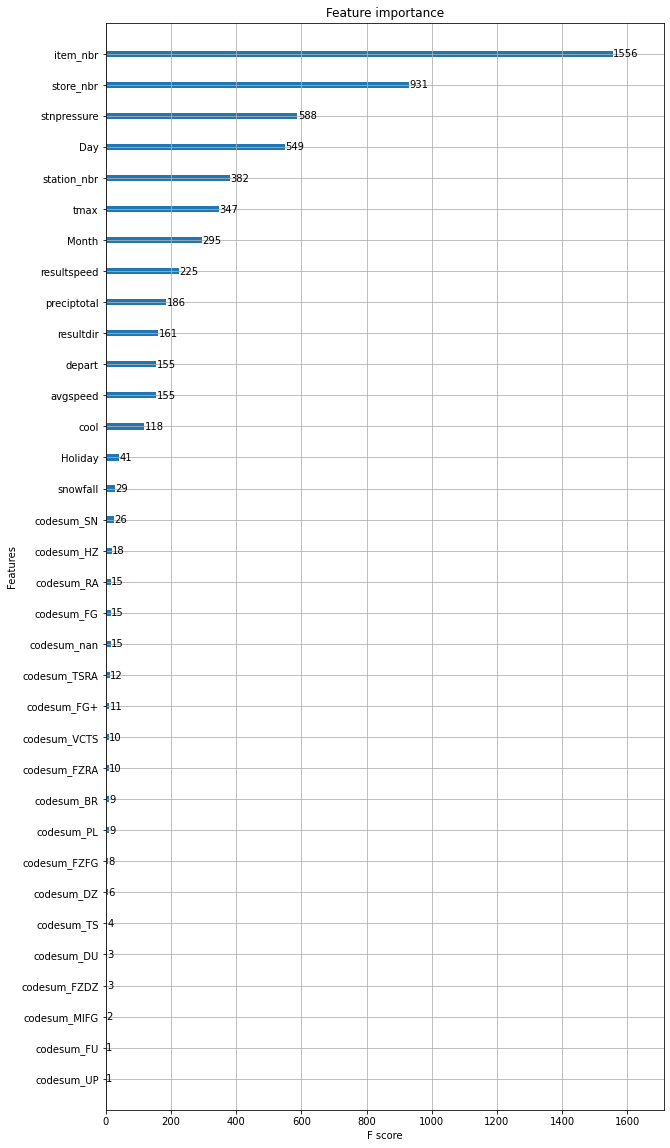

In [ ]:
plot_importance(model)
#pyplot.rcParams["figure.figsize"] = (14, 7)
pyplot.show()

In [ ]:
y_predXGBRegressor = model.predict(X_test)
Evaluation_Metrics (model,y_test,y_predXGBRegressor,"XGBRegressor")


'Mean Absolute Error(MAE)' for the model -  XGBRegressor is:  16.433493532214836
'Mean Squared Error(MSE)' for the model -  XGBRegressor is:  627.0443722182928
'Root Mean Squared Error(RMSE)' for the model -  XGBRegressor is:  25.040854063276132
NO 'Root Mean Squared Log Error(RMSLE)' for the model -  XGBRegressor  as, prediction have negative values.
'R Squared (R2)' for the model -  XGBRegressor is:  0.16878822767722979

-----------------------------------------------------------------------------------------

'Model Train Score' for the model -  XGBRegressor is:  0.7771205501968009

-----------------------------------------------------------------------------------------

'Model Test Score' for the model -  XGBRegressor is:  0.16878822767722979


In [ ]:
cross_validate(model)

Mean RMSE: 15.745 (0.141)

-----------------------------------------------------------------------------------------
Mean RMSLE: nan (nan)

-----------------------------------------------------------------------------------------
Mean MAE: 10.406 (0.101)

-----------------------------------------------------------------------------------------


In [ ]:
model_params = {
    'XGBRegressor': {
        'model': XGBRegressor(),
        'params' : {
          'eta': [.1,.2],
			    'gamma': [0,1],
           'max_depth': [4,6,8]
			     #'min_child_weight':[1,2]
        }  
    }
}
hyperparametertuning(model_params)

[15:49:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# SVR (Support vector regressor)

In [ ]:
#X_train, X_test, y_train, y_test
from sklearn.svm import SVR 
regressorSVR = SVR(kernel = 'rbf') #kernel = 'rbf'
regressorSVR.fit(X_train, y_train)

SVR()

In [ ]:
y_predSVR = regressorSVR.predict(X_test)
Evaluation_Metrics (regressorSVR,y_test,y_predSVR,"SVR (Support vector regressor)")


'Mean Absolute Error(MAE)' for the model -  SVR (Support vector regressor) is:  18.818406797103272
'Mean Squared Error(MSE)' for the model -  SVR (Support vector regressor) is:  673.7867578789894
'Root Mean Squared Error(RMSE)' for the model -  SVR (Support vector regressor) is:  25.95740275680503
NO 'Root Mean Squared Log Error(RMSLE)' for the model -  SVR (Support vector regressor)  as, prediction have negative values.
'R Squared (R2)' for the model -  SVR (Support vector regressor) is:  0.10682639060631793

-----------------------------------------------------------------------------------------

'Model Train Score' for the model -  SVR (Support vector regressor) is:  0.09036113892631403

-----------------------------------------------------------------------------------------

'Model Test Score' for the model -  SVR (Support vector regressor) is:  0.10682639060631793


In [ ]:
cross_validate(regressorSVR)

#Output: Mean RMSE: 31.229 (0.100)

##Stopped Execution as it was taking time and not req for MAE

Mean RMSE: 31.229 (0.100)

-----------------------------------------------------------------------------------------


KeyboardInterrupt: ignored

In [ ]:
model_params = {
    'SVR': {
        'model': SVR(),
        'params' : {
            'kernel': [ 'rbf','poly'],#'linear','poly', , 'sigmoid', 'precomputed'
			      'gamma': ['scale','auto'],
            'C': [1,2,3]
        }  
    }
}
hyperparametertuning(model_params)

+----+---------+--------------+---------------------------------------------+
|    | model   |   best_score | best_params                                 |
|----+---------+--------------+---------------------------------------------|
|  0 | SVR     |    0.0911346 | {'C': 3, 'gamma': 'scale', 'kernel': 'rbf'} |
+----+---------+--------------+---------------------------------------------+


# Random Forest

In [55]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 
 # create regressor object
RFregressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
RFregressor.fit(X_train, y_train) 

RandomForestRegressor(random_state=0)

In [ ]:
y_predRFregressor = RFregressor.predict(X_test)
Evaluation_Metrics (RFregressor,y_test,y_predRFregressor,"Random Forest")


'Mean Absolute Error(MAE)' for the model -  Random Forest is:  18.529043620083392
'Mean Squared Error(MSE)' for the model -  Random Forest is:  745.7857656063524
'Root Mean Squared Error(RMSE)' for the model -  Random Forest is:  27.309078446669567
'Root Mean Squared Log Error(RMSLE)' for the model -  Random Forest is:  1.190416229245406
'R Squared (R2)' for the model -  Random Forest is:  0.011384304734749162

-----------------------------------------------------------------------------------------

'Model Train Score' for the model -  Random Forest is:  0.9684715215735444

-----------------------------------------------------------------------------------------

'Model Test Score' for the model -  Random Forest is:  0.011384304734749162


In [ ]:
cross_validate(RFregressor)

Mean RMSE: 15.488 (0.147)

-----------------------------------------------------------------------------------------
Mean RMSLE: 0.496 (0.004)

-----------------------------------------------------------------------------------------
Mean MAE: 9.882 (0.076)

-----------------------------------------------------------------------------------------


In [ ]:
##Unfortunately due to resource crunch below code did not complete executing. Tried multiple times.
##So Assumed this will have accuracy level as .30
model_params = {
    'RandomForestRegressor' : {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [100,120,150],
			      'criterion': ['absolute_error']
        }  
    }
}

hyperparametertuning(model_params)

# Hyperparameter tuning, finding best model

In [ ]:
'''
#Below code will help us running all the models together & find best scored model & corresponding parameter.
#As it took time to execute the below code & was keep running, so for each model it ran separetly
from sklearn.model_selection import GridSearchCV
#X_train, X_test, y_train, y_test
model_params = {
    'Lasso': {
        'model': linear_model.Lasso(),
        'params' : {
          'alpha': [1,10,20,30,40,50,60,70,80],
          'max_iter': [1000,2000,3000,4000]
			     #'fit_intercept': [True,False]
        }  
    },

    'XGBRegressor': {
        'model': XGBRegressor(),
        'params' : {
          'eta': [.1,.2,.3,.4,.5],
			    'gamma': [0,1,2,3]
           #'max_depth': [2,4,6,7,8],
			     #'min_child_weight':[1,2]
        }  
    },
    'SVR': {
        'model': SVR(),
        'params' : {
            'kernel': [ 'rbf'],#'linear','poly', , 'sigmoid', 'precomputed'
			       #'gamma': ['scale','auto'],
            'C': [1,2,3]
        }  
    },
    'RandomForestRegressor' : {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [100,150,200],
			      'criterion': ['absolute_error']
        }  
    }
}

scores = []

#RandomizedSearchCV
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_CV_Score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_CV_Score
'''

"\n#Below code will help us running all the models together & find best scored model & corresponding parameter.\n#As it took time to execute the below code & was keep running, so for each model it ran separetly\nfrom sklearn.model_selection import GridSearchCV\n#X_train, X_test, y_train, y_test\nmodel_params = {\n    'Lasso': {\n        'model': linear_model.Lasso(),\n        'params' : {\n          'alpha': [1,10,20,30,40,50,60,70,80],\n          'max_iter': [1000,2000,3000,4000]\n\t\t\t     #'fit_intercept': [True,False]\n        }  \n    },\n\n    'XGBRegressor': {\n        'model': XGBRegressor(),\n        'params' : {\n          'eta': [.1,.2,.3,.4,.5],\n\t\t\t    'gamma': [0,1,2,3]\n           #'max_depth': [2,4,6,7,8],\n\t\t\t     #'min_child_weight':[1,2]\n        }  \n    },\n    'SVR': {\n        'model': SVR(),\n        'params' : {\n            'kernel': [ 'rbf'],#'linear','poly', , 'sigmoid', 'precomputed'\n\t\t\t       #'gamma': ['scale','auto'],\n            'C': [1,2,3]

In [34]:
import pandas as pd
Values = [
          ['Lasso Regression',0.106515,26.06111,30.729,{'alpha': 1, 'fit_intercept': True, 'max_iter': 5}],
          ['XGBRegressor',0.730481,25.04085,15.745,{'eta': 0.1, 'gamma': 1, 'max_depth': 6}],
          ['SVR (Support vector regressor)',0.091134,25.9574,31.229,{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}],
          ['Random Forest',0.300001,27.30907,15.488, 'best_params']
]
df_Score = pd.DataFrame(Values,columns = ['model','best_score','RMSE', 'Cross Val - RMSE','Best_Params'])
from tabulate import tabulate 
print(tabulate(df_Score, headers = 'keys', tablefmt = 'psql'))


+----+--------------------------------+--------------+---------+--------------------+----------------------------------------------------+
|    | model                          |   best_score |    RMSE |   Cross Val - RMSE | Best_Params                                        |
|----+--------------------------------+--------------+---------+--------------------+----------------------------------------------------|
|  0 | Lasso Regression               |     0.106515 | 26.0611 |             30.729 | {'alpha': 1, 'fit_intercept': True, 'max_iter': 5} |
|  1 | XGBRegressor                   |     0.730481 | 25.0408 |             15.745 | {'eta': 0.1, 'gamma': 1, 'max_depth': 6}           |
|  2 | SVR (Support vector regressor) |     0.091134 | 25.9574 |             31.229 | {'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}        |
|  3 | Random Forest                  |     0.300001 | 27.3091 |             15.488 | best_params                                        |
+----+---------------------